In [1]:
import os
import string
from collections import Counter
from datetime import datetime

import nltk
import pandas as pd
import matplotlib
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.util import ngrams

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 1000
matplotlib.rcParams['lines.linewidth'] = 1.0

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
def my_ngrams(tokens, rg):
    ngrms = []
    for i in range(rg[0], rg[1] + 1):
        ngrms_aux = [ngrm for ngrm in ngrams(tokens, i)]
        ngrms.extend(ngrms_aux)
    return ngrms

# Preparing data

In [4]:
original_keywords = ["Picard", "Kirk", "Sulu", "Uhura", "Spock", "McCoy", "Bones", "Scotty", "Chekhov", "Crusher", "Nurse Chapel", "Sarek", "Nero", "Khan", "Data", "Pike", "Star Trek", "Klingon", "Vulcan", "Romulan", "Star fleet", "Starship Enterprise", "Delta Vega", "Earth", "Orion", "Romulan Narada", "Stardate", "Transporter beam", "Beam me up,\? Scotty", "Kobayashi Maru", "Space,\? The Final Frontier", "Energize", "Vulcan Salute", "Prime Directive", "Live long and prosper", "LLAP", "I'm a doctor,\? not a", "KHAAA\+N", "When you eliminate the impossible,\? whatever remains,\? however improbable,\? must be the truth", "Without followers,\? evil cannot spread", "The needs of the many outweigh the needs of the few", "Highly illogical", "to boldly go where no man has gone before", "I'm giving her all she's got,\? Captain", "Nuclear wessels", "Set phasers to stun", "Resistance is futile", "I have been and always shall be your friend"]

In [5]:
print(original_keywords)

['Picard', 'Kirk', 'Sulu', 'Uhura', 'Spock', 'McCoy', 'Bones', 'Scotty', 'Chekhov', 'Crusher', 'Nurse Chapel', 'Sarek', 'Nero', 'Khan', 'Data', 'Pike', 'Star Trek', 'Klingon', 'Vulcan', 'Romulan', 'Star fleet', 'Starship Enterprise', 'Delta Vega', 'Earth', 'Orion', 'Romulan Narada', 'Stardate', 'Transporter beam', 'Beam me up,\\? Scotty', 'Kobayashi Maru', 'Space,\\? The Final Frontier', 'Energize', 'Vulcan Salute', 'Prime Directive', 'Live long and prosper', 'LLAP', "I'm a doctor,\\? not a", 'KHAAA\\+N', 'When you eliminate the impossible,\\? whatever remains,\\? however improbable,\\? must be the truth', 'Without followers,\\? evil cannot spread', 'The needs of the many outweigh the needs of the few', 'Highly illogical', 'to boldly go where no man has gone before', "I'm giving her all she's got,\\? Captain", 'Nuclear wessels', 'Set phasers to stun', 'Resistance is futile', 'I have been and always shall be your friend']


In [6]:
ambiguous_keywords = [
    'Bones',
    'Khan',
    'Data',
    'Earth',
    'Energize',
]

In [7]:
keywords = list(set(original_keywords).difference(ambiguous_keywords))
keywords = [w.replace('\\', '').lower() for w in keywords]
keywords.sort()

In [8]:
print(keywords)

['beam me up,? scotty', 'chekhov', 'crusher', 'delta vega', 'highly illogical', 'i have been and always shall be your friend', "i'm a doctor,? not a", "i'm giving her all she's got,? captain", 'khaaa+n', 'kirk', 'klingon', 'kobayashi maru', 'live long and prosper', 'llap', 'mccoy', 'nero', 'nuclear wessels', 'nurse chapel', 'orion', 'picard', 'pike', 'prime directive', 'resistance is futile', 'romulan', 'romulan narada', 'sarek', 'scotty', 'set phasers to stun', 'space,? the final frontier', 'spock', 'star fleet', 'star trek', 'stardate', 'starship enterprise', 'sulu', 'the needs of the many outweigh the needs of the few', 'to boldly go where no man has gone before', 'transporter beam', 'uhura', 'vulcan', 'vulcan salute', 'when you eliminate the impossible,? whatever remains,? however improbable,? must be the truth', 'without followers,? evil cannot spread']


In [9]:
%%time

dtypes = {
    'author': str,
    'body': str,
    'controversiality': str,
    'created_utc': pd.tslib.Timestamp,
    'distinguished': str,
    'downs': str,
    'gilded': str,
    'id': str,
    'name': str,
    'parent_id': str,
    'score': str,
    'subreddit': str,
    'ups': str,
    'month': pd.tslib.Timestamp,
    'year': pd.tslib.Timestamp,
}

reddit_df = pd.read_csv('reddit.csv', header=0, dtype=dtypes, parse_dates=['created_utc', 'month', 'year'])
reddit_df = reddit_df.fillna('')

CPU times: user 28 s, sys: 1.13 s, total: 29.1 s
Wall time: 29.1 s


In [10]:
len(reddit_df)

2669814

In [11]:
reddit_df.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
0,gschizas,same in greek. my personal peeve: quite a lot ...,0,2007-10-15 15:22:33,,0.0,0,c029c79,t1_c029c79,t1_c029brz,13,programming,13,2007-10-01,2007-01-01
1,[deleted],&gt;they also decided to rig a thermal barrier...,0,2007-10-16 05:11:09,,0.0,0,c029g6h,t1_c029g6h,t3_5ye94,2,programming,2,2007-10-01,2007-01-01
2,johnmudd,&gt; by the time a child born today graduates ...,0,2007-10-16 07:00:36,,0.0,0,c029gfc,t1_c029gfc,t3_5ye9w,1,science,1,2007-10-01,2007-01-01
3,feliniti,nero 8 - bloated waste of money. unless you ha...,0,2007-10-16 07:10:27,,0.0,0,c029gge,t1_c029gge,t3_5yej4,1,reddit.com,1,2007-10-01,2007-01-01
4,masklinn,&gt; i wonder what happens if you started clea...,0,2007-10-16 11:27:15,,0.0,0,c029hiy,t1_c029hiy,t1_c029h3y,3,reddit.com,3,2007-10-01,2007-01-01


# Analyzing data

## Keywords

In [12]:
%%time

keywords_dict = {}
for k in keywords:
    keywords_dict[k] = reddit_df['body'].str.count(k).sum()

CPU times: user 2min 20s, sys: 643 ms, total: 2min 21s
Wall time: 2min 21s


In [13]:
keywords_counter = Counter(keywords_dict)

In [14]:
keywords_counter.most_common()

[('star trek', 738866),
 ('kirk', 280755),
 ('mccoy', 253387),
 ('orion', 240616),
 ('vulcan', 227583),
 ('pike', 195162),
 ('picard', 173336),
 ('spock', 138967),
 ('klingon', 115210),
 ('nero', 114120),
 ('crusher', 108201),
 ('scotty', 80689),
 ('romulan', 61021),
 ('chekhov', 37332),
 ('prime directive', 26544),
 ('resistance is futile', 22449),
 ('sulu', 17900),
 ('uhura', 12816),
 ('live long and prosper', 12422),
 ('star fleet', 10832),
 ('khaaa+n', 7343),
 ('stardate', 7265),
 ('llap', 6978),
 ('starship enterprise', 4862),
 ('kobayashi maru', 4349),
 ('the needs of the many outweigh the needs of the few', 3952),
 ('beam me up,? scotty', 3537),
 ('highly illogical', 3437),
 ("i'm a doctor,? not a", 2897),
 ('sarek', 2881),
 ('vulcan salute', 1635),
 ('nuclear wessels', 1454),
 ('to boldly go where no man has gone before', 970),
 ('space,? the final frontier', 791),
 ('transporter beam', 739),
 ('nurse chapel', 589),
 ('set phasers to stun', 409),
 ('delta vega', 296),
 ("i'm gi

In [15]:
keywords_sr = pd.Series(keywords_dict)

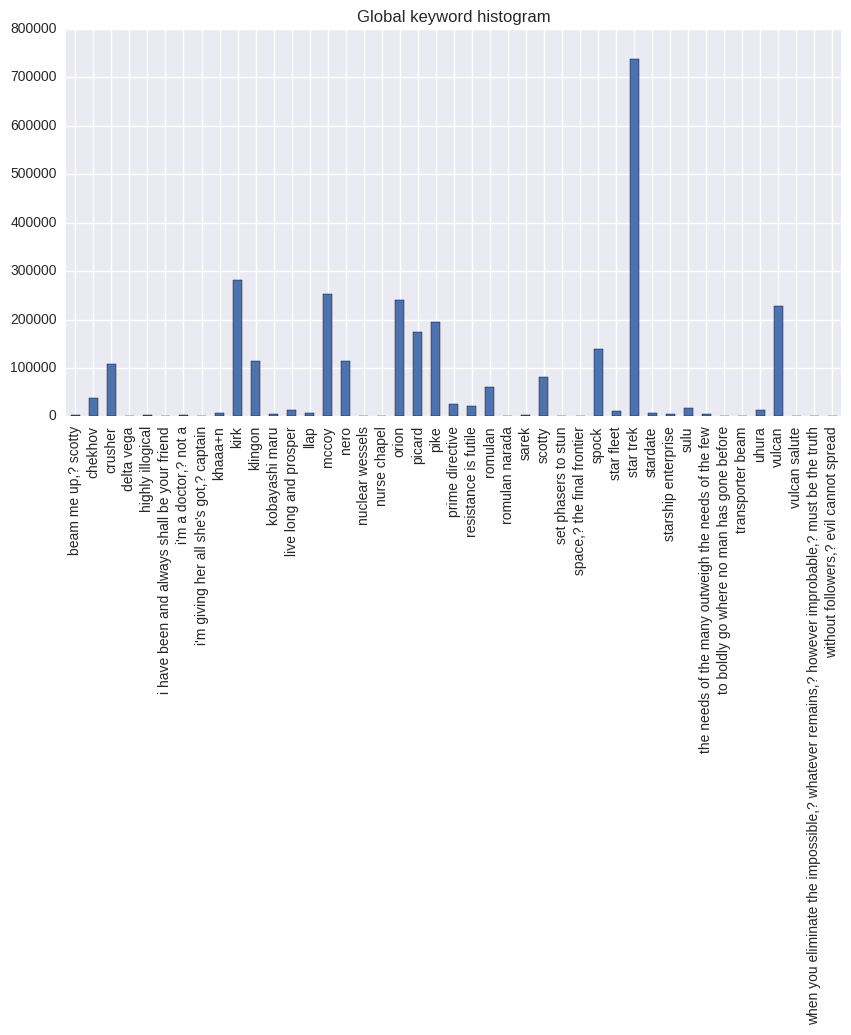

In [16]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Global keyword histogram',
)

## Other words

In [17]:
# %%time

# hist = Counter()
# for text_ in reddit_df['body']:
    
#     list_ = [
#         w
#         for w in nltk.word_tokenize(text_)
#         if len(w) > 2 and w not in stopwords.words('english')
#     ]
#     counter_ = Counter(list_)
#     hist += counter_

# CPU times: user days..., total: days...
# Wall time: days...

In [18]:
# hist_sr = pd.Series(hist)

In [19]:
# hist_sr.to_csv('hist.csv')

In [20]:
hist_sr = pd.Series.from_csv('hist.csv')

In [21]:
sorted_hist_sr = hist_sr.sort_values(ascending=False)

In [22]:
sorted_hist_sr.head(100)

n't          1368858
star          849101
like          787049
trek          782206
http          711018
would         687598
one           568398
...           495993
get           434652
think         419850
people        384687
time          371768
really        346231
also          344074
good          334711
even          324239
could         320675
amp           310748
're           306692
much          288249
know          279927
see           275497
kirk          261985
first         256223
https         253753
well          249147
've           245852
make          243004
mccoy         239518
way           234845
              ...   
work          134045
sure          133587
look          131771
always        129868
series        126554
spock         125645
last          125219
since         124841
long          122863
team          121644
year          121064
might         119176
space         118526
bad           115483
play          115027
little        114678
used         

## Keywords in top words

In [23]:
P = 1

In [24]:
top_sorted_hist_sr = sorted_hist_sr[:len(sorted_hist_sr) * P // 100]

In [25]:
threshold = top_sorted_hist_sr[-1]

In [26]:
threshold

278

#### Yes

In [27]:
for k, f in keywords_counter.most_common():
    if f >= threshold:
        print(k, '-', f)

star trek - 738866
kirk - 280755
mccoy - 253387
orion - 240616
vulcan - 227583
pike - 195162
picard - 173336
spock - 138967
klingon - 115210
nero - 114120
crusher - 108201
scotty - 80689
romulan - 61021
chekhov - 37332
prime directive - 26544
resistance is futile - 22449
sulu - 17900
uhura - 12816
live long and prosper - 12422
star fleet - 10832
khaaa+n - 7343
stardate - 7265
llap - 6978
starship enterprise - 4862
kobayashi maru - 4349
the needs of the many outweigh the needs of the few - 3952
beam me up,? scotty - 3537
highly illogical - 3437
i'm a doctor,? not a - 2897
sarek - 2881
vulcan salute - 1635
nuclear wessels - 1454
to boldly go where no man has gone before - 970
space,? the final frontier - 791
transporter beam - 739
nurse chapel - 589
set phasers to stun - 409
delta vega - 296


#### No

In [28]:
for k, f in keywords_counter.most_common():
    if f < threshold:
        print(k, '-', f)

i'm giving her all she's got,? captain - 186
i have been and always shall be your friend - 131
when you eliminate the impossible,? whatever remains,? however improbable,? must be the truth - 40
without followers,? evil cannot spread - 7
romulan narada - 3
